# Learning and Decision Making

## Laboratory 6: Reinforcement learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. The windy gridworld domain

Consider the larger version of the windy gridworld domain depicted in the figure below.

<img src="windy.png" width="400px">

In it, a boat must navigate a 7 &times; 10 gridworld, to reach the goal cell, marked with _G_. There is a crosswind upward through the middle of the grid, in the direction indicated by the gray arrows. The boat has available the standard four actions -- _Up_, _Down_, _Left_ and _Right_. In the region affected by the wind, however, the resulting next state is shifted upward as a consequence of the crosswind, the strength of which varies from column to column. The strength of the wind is given below each column, and corresponds to the number of cells that the movement is shifted upward. For example, if the boat is one cell to the right of the goal, then the action _Left_ takes you to the cell just above the goal.

The agent pays a cost of 1 in every step before reaching the goal. The problem can be described as an MDP $(\mathcal{X},\mathcal{A},\mathbf{P},c,\gamma)$ as follows.

In [1]:
%matplotlib notebook
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

np.set_printoptions(threshold=10)

# Problem specific parameters
WIND = (0, 0, 0, 1, 1, 1, 2, 2, 1, 0)
nrows = 7
ncols = 10
init = [3, 0]
goal = [3, 7]

# States
X = [[x, y] for x in range(nrows) for y in range(ncols)]
nX = len(X)

# Actions
A = ['U', 'D', 'L', 'R']
nA = len(A)

# Transition probabilities
P = dict()
P['U'] = np.zeros((nX, nX))
P['D'] = np.zeros((nX, nX))
P['L'] = np.zeros((nX, nX))
P['R'] = np.zeros((nX, nX))

for i in range(len(X)):
    x = X[i]
    y = dict()
    
    y['U'] = [x[0] - WIND[x[1]] - 1, x[1]]
    y['D'] = [x[0] - WIND[x[1]] + 1, x[1]]
    y['L'] = [x[0] - WIND[x[1]], x[1] - 1]
    y['R'] = [x[0] - WIND[x[1]], x[1] + 1]
    
    for k in y:
        y[k][0] = max(min(y[k][0], nrows - 1), 0)
        y[k][1] = max(min(y[k][1], ncols - 1), 0)
        j = X.index(y[k])
        P[k][i, j] = 1

c = np.ones((nX, nA))
c[X.index(goal), :] = 0

gamma = 0.99

#MDP dictionary structure
mdp = {"X": X, "A": A, "Pa's": [P['U'], P['D'], P['L'], P['R']], "C":c} 

# -- Pretty print

print('\n- MDP problem specification: -\n')

print('States:')
print(np.array(X))

print('\nActions:')
print(A)

print('\nTransition probabilities:')
for a in A:
    print('Action', a)
    print(P[a])
    
print('\ncost:')
print(c)

print('\nStart state:', init, '- index:', X.index(init))
print('\nGoal state:', goal, '- index:', X.index(goal))


- MDP problem specification: -

States:
[[0 0]
 [0 1]
 [0 2]
 ..., 
 [6 7]
 [6 8]
 [6 9]]

Actions:
['U', 'D', 'L', 'R']

Transition probabilities:
Action U
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Action D
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
Action L
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
Action R
[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]

cost:
[[ 1.  1

---

#### Activity 1.        

Compute the optimal _Q_-function for the MDP defined above using value iteration. As your stopping condition, use an error between iterations smaller than `1e-8`.

---

In [2]:
"""
mdp_aux = {"X": ['0', 'A', 'B'], 
           "A": ['a', 'b'], 
           "Pa's": [[[0, 1, 0], [0, 1, 0], [0, 0, 1]], [[0, 0, 1], [0, 1, 0], [0, 0, 1]]], 
           "C": [[1, 0.5], [0, 0], [1, 1]]} 
"""

#@brief: 
#      This function computes the valueIteration algorithm to find the Q function.
#
#@param: - MDP (dictionary with respective fields)
#        - tolerance, which is used to stop the algorithm when Jnew and J are close by a small factor
#        - gamma, which represents the inflation.
#
#@return: 
#        returns the matrix that represents the Q function and the number of iterations required to compute it.
def valueIterationQ(MDP, tolerance, gamma):
    J = np.zeros((len(MDP["X"]), 1)) # initialize J
    err = 1
    i=0
    while err > tolerance:
        
        Qa = [None]*len(MDP["A"]) #initialize empty list for Q values for actions a in A
        
        for a in range(0, len(MDP["A"])):
            Qa[a] = MDP["C"][:,[a]] + gamma * MDP["Pa's"][a].dot(J)
        
        Jnew = np.min(([column for column in Qa]), axis=0)
        err = np.linalg.norm(Jnew - J)
        i += 1
        J = Jnew
        
    # this extra cycle is just for formating Q based on the Qa values computed
    Q = np.zeros((len(MDP["X"]), len(MDP["A"])))
    for a in range(0, len(MDP["A"])):
        Q[:,a] = Qa[a][:,0]
        
    return (Q, i)

Qstar, iterations = valueIterationQ(MDP=mdp, tolerance=1e-8, gamma=gamma)

print (Qstar)
print (iterations)

[[ 88.97864977  88.97864977  88.97864977  88.867323  ]
 [ 88.867323    88.867323    88.97864977  88.75487172]
 [ 88.75487172  88.75487172  88.867323    88.64128457]
 ..., 
 [ 87.18534603  87.44035764  88.29359257  87.31349257]
 [ 87.31349257  87.44035764  87.44035764  87.56595406]
 [ 87.56595406  87.56595406  87.44035764  87.56595406]]
2039


---

#### Activity 2.        

Write down a Python function that, given a Q-function $Q$ and a state $x$, selects a random action using the $\epsilon$-greedy policy obtained from $Q$ for state $x$. Your function should receive an optional parameter, corresponding to $\epsilon$, with default value of 0.1. 

**Note:** In the case of two actions with the same value, your $\epsilon$-greedy policy should randomize between the two.

---

In [7]:
import random

def eGreedyHeuristic(MDP, Q, x, e=0.1):
    greedy = random.randrange(0, 100) < (1 - e)*100
    
    # exploration case
    if not greedy:
        return random.randrange(0, len(MDP['A']))
    
    min = Q[x][0]
    action = 0
    for a in range(1, len(MDP['A'])):
        if Q[x][a] < min:
            min = Q[x][a]
            action = a

    # we now want to count how many actions have the min value and select randomly between them if count > 1
    # aux is a list that stores the indexes of the actions with the value equal to the min
    aux = []
    for a in range(0, len(MDP['A'])):
        if Q[x][a] == min:
            aux.append(a)
            
    if len(aux) > 1:
        #print('Entrei!')
        return aux[random.randrange(0, len(aux))]
    
    return action


### 2. Model-based learning

You will now run the model-based learning algorithm discussed in class, and evaluate its learning performance.

---

#### Activity 3.        

Run the model-based reinforcement learning algorithm discussed in class to compute $Q^*$ for 100,000 iterations. Initialize each transition probability matrix as the identity and the cost function as all-zeros. Use an $\epsilon$-greedy policy with $\epsilon=0.1$ (use the function from Activity 2). Note that, at each step,

* You will need to select an action according to the $\epsilon$-greedy policy;
* The state and action, you will then compute the cost and generate the next state; 
* With this transition information (state, action, cost, next-state), you can now perform an update. 
* When updating the components $(x,a)$ of the model, use the step-size

$$\alpha_t=\frac{1}{N_t(x,a)+1},$$

where $N_t(x,a)$ is the number of visits to the pair $(x,a)$ up to time step $t$.

In order to ensure that your algorithm visits every state and action a sufficient number of times, after the boat reaches the goal cell, make one further step, the corresponding update, and then reset the position of the boat to a random state in the environment.

Plot the norm $\|Q^*-Q^{(k)}\|$ every 500 iterations of your method, where $Q^*$ is the optimal _Q_~function computed in Activity 1.

**Note:** The simulation may take a bit. Don't despair.

---

<IPython.core.display.Javascript object>


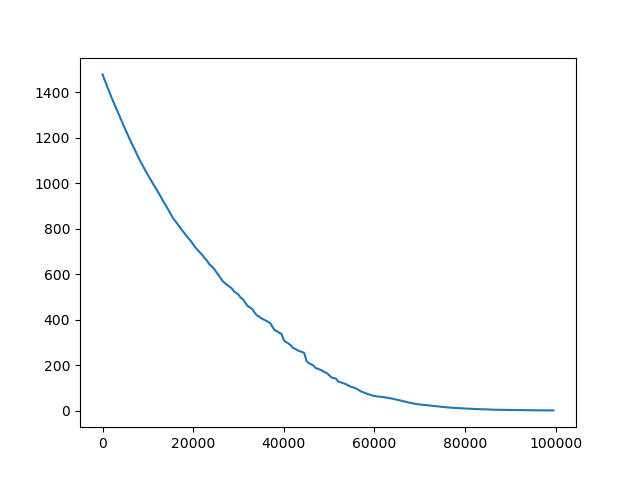

In [12]:
def updateCostMatrix(cost_matrix, state, action, cost, alfa):
    # this follows the formula: Ct+1(x, a) = Ct(x, a) + alfa(Ct - Ct(x, a))
    cost_matrix[state][action] = cost_matrix[state][action] + alfa*(cost - cost_matrix[state][action])

def updateTransitionProbabilitiesMatrix(Pa, state, dest_state, alfa):
    # this follows the formula: Pt+1(y|x,a) = Pt(y|x,a) + alfa(I(Xt+1 = y) - Pt(y|x,a))
    Pa[state][:] *= (1-alfa)
    Pa[state][dest_state] += alfa

# we start by creating and MDP with the cost function and transition probabilities Matrixes empty.
mb_C = np.zeros((nX, nA))
mb_P = dict()
mb_P['U'] = np.eye(nX)
mb_P['D'] = np.eye(nX)
mb_P['L'] = np.eye(nX)
mb_P['R'] = np.eye(nX)

# the MDP in his initial state is defined as the following dictionary:
mb_mdp = {"X": X, "A": A, "Pa's": [mb_P['U'], mb_P['D'], mb_P['L'], mb_P['R']], "C":mb_C}

# x will be the current state for a trajectory.
x = X.index(init)
N = np.zeros((len(mdp['X']), len(mdp['A']))) # initialize N
norms_to_plot_3 = []
iterations_list_3 = []

mb_Q = np.zeros((nX, nA))

i = 0
reset = False
while i < 100000:
    # selection of an action based on eGreedy heuristic computed in activity 2.
    action = eGreedyHeuristic(mb_mdp, mb_Q, x)
    
    # compute the destiny state based on the underlying mdp. Which is determinist for every state action pair.
    for j in range(len(mdp['X'])):
        if mdp["Pa's"][action][x][j] == 1:
            dest_state = j
            break
    
    N[x][action] += 1
    # decrease the learning rate with nr of actions a for a state x.
    alfa = 1 / N[x][action]
    
    # cost obtained based on the underlying mdp.
    cost = mdp['C'][x][action]
    
    #print('t:', i, '- (', x, ',', action,',',cost,',',dest_state,')')
    # finally we have all we need to update Matrix P and C based on the mean formula form theoretical lessons.
    updateCostMatrix(mb_mdp['C'], x, action, cost, alfa)
    updateTransitionProbabilitiesMatrix(mb_mdp["Pa's"][action], x, dest_state, alfa)
    
    mb_Q[x][action] = mb_mdp["C"][x][action] + gamma * mb_mdp["Pa's"][action][x].dot(mb_Q.min(axis=1,keepdims=True))    

    # extra requirements from the activity.
    if reset:
        x = random.randrange(0, nX)
        reset = False
    elif (dest_state == X.index(goal)):
        reset = True
        x = dest_state
    else:
        x = dest_state
        
    if not i%500:
        #Qk = valueIterationQ(MDP=mb_mdp, tolerance=1e-8, gamma=gamma)[0]
        iterations_list_3.append(i)
        norms_to_plot_3.append(la.norm(Qstar - mb_Q))
    i += 1
    
f = plt.figure(1)
plt.plot(iterations_list_3, norms_to_plot_3)
f.show()
           

### 3. Temporal-difference learning

You will now run both Q-learning and SARSA, and compare their learning performance with that of the model-based method just studied.

---

#### Activity 4.        

Repeat Activity 3 but using the _Q_-learning algorithm with a learning rate $\alpha=0.3$.

---

<IPython.core.display.Javascript object>


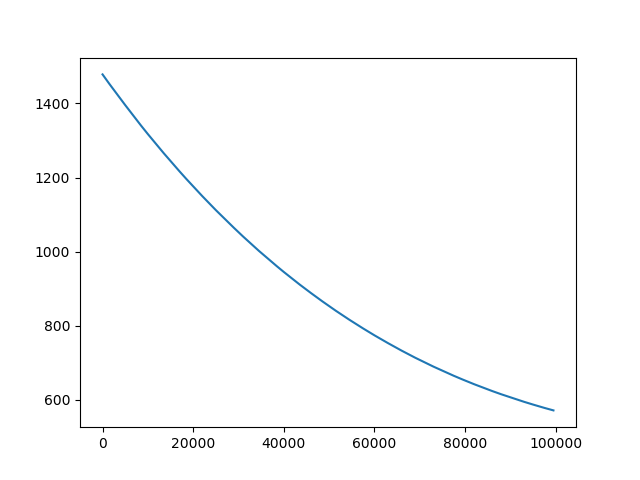

In [13]:
GAMMA = 0.95
Q = np.zeros((len(mdp["X"]), len(mdp["A"]))) # initialize Q
norms_to_plot_4 = []
iterations_list_4 = []

def q_learning(InitialState, iterations):
    
    state_t = InitialState
    action = eGreedyHeuristic(mdp, Q, state_t, e=0.1)
    cost = mdp['C'][state_t][action]
    state_t_1 = X.index(X[np.where(mdp["Pa's"][action][state_t]==1)[0][0]])
      
    for i in range(0, iterations):
        q_update(state_t,action,cost,state_t_1)
    
        action = eGreedyHeuristic(mdp, Q, state_t_1, e=0.1)
        cost = mdp['C'][state_t_1][action]
        
        previous = state_t_1
        state_t_1 = X.index(X[np.where(mdp["Pa's"][action][previous]==1)[0][0]])
        state_t=previous
        
        if not i%500:
            iterations_list_4.append(i)
            norms_to_plot_4.append(la.norm(Qstar - Q))
    

def q_update(state, action, cost, nextState):  
    ALPHA=0.3
    mini = min(Q[nextState,:])
    Q[state][action] = Q[state][action] + ALPHA * (cost + gamma * mini - Q[state][action])


x = X.index(init)
q_learning(x, 100000)

q_figure = plt.figure(2)
plt.plot(iterations_list_4, norms_to_plot_4)
q_figure.show()


---

#### Activity 5.

Repeat Activity 4 but using the SARSA algorithm.

---

<IPython.core.display.Javascript object>


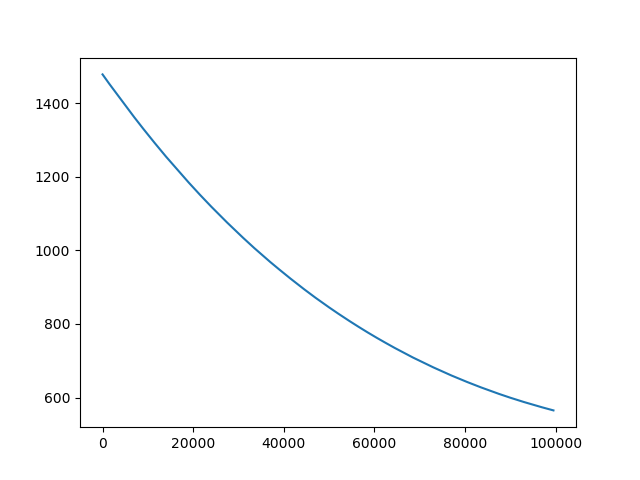

<IPython.core.display.Javascript object>


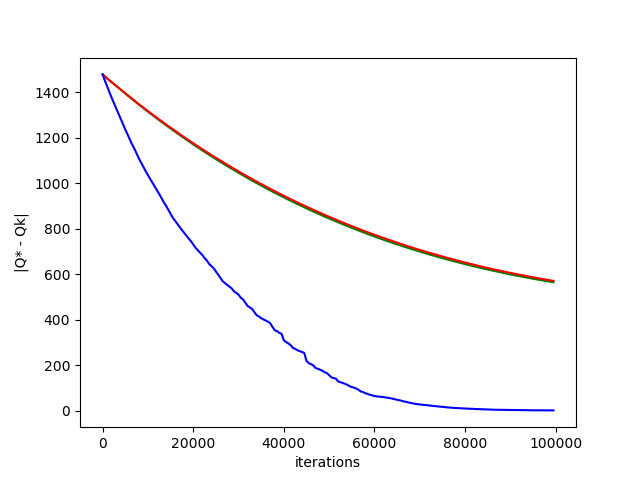

In [17]:
sarsaMatrix = np.zeros((len(mdp["X"]), len(mdp["A"])))
GAMMA = 0.95
norms_to_plot_5 = []
iterations_list_5 = []

def sarsa(InitialState, iterations):
    
    state_t = InitialState
    action_t = eGreedyHeuristic(mdp, sarsaMatrix, state_t, e=0.1)
    cost = mdp['C'][state_t][action_t]
    state_t_1 = X.index(X[np.where(mdp["Pa's"][action_t][state_t]==1)[0][0]])
    action_t_1 = eGreedyHeuristic(mdp, sarsaMatrix, state_t_1, e=0.1)
    
    for i in range(0, iterations):
        #print(state_t,action,cost,state_t_1)
        sarsa_update(state_t, action_t, cost, state_t_1, action_t_1)
        
        action_t = eGreedyHeuristic(mdp, sarsaMatrix, state_t_1, e=0.1)
        cost = mdp['C'][state_t_1][action_t]
        previous = state_t_1
        state_t_1 = X.index(X[np.where(mdp["Pa's"][action_t][previous]==1)[0][0]])
        state_t = previous
        action_t_1 = eGreedyHeuristic(mdp, sarsaMatrix, state_t_1, e=0.1)
        
        if not i%500:
            iterations_list_5.append(i)
            norms_to_plot_5.append(la.norm(Qstar - sarsaMatrix))

def sarsa_update(state, action, cost, nextState, nextAction):
    ALPHA=0.3
    sarsaMatrix[state][action] = sarsaMatrix[state][action] + ALPHA * (cost + gamma * sarsaMatrix[nextState][nextAction] - sarsaMatrix[state][action]) 
    #print (Q[state][action])
    
x = X.index(init)
sarsa(x, 100000)

sarsa_figure = plt.figure(3)
plt.plot(iterations_list_5, norms_to_plot_5)
sarsa_figure.show()

comparation = plt.figure(4)
plt.plot(iterations_list_5, norms_to_plot_5, color='green')
plt.plot(iterations_list_4, norms_to_plot_4, color='red')
plt.plot(iterations_list_3, norms_to_plot_3, color='blue')
plt.ylabel('|Q* - Qk|')
plt.xlabel('iterations')
comparation.show()

---

#### Activity 6.

Discuss the differences observed between the performance of the three methods.

---

## MB learning:
Este modelo, apesar de demorar bastantes iterações (~75k) a convergir, chega ao Q*.

## Q-learning:
O Q-learning (que é um algoritmo off-policy pois aprende uma política enquanto segue outra) com a heuristica do e-Greedy (calculada na actividade 2) não chega ao Q*. No entanto, se permitissemos que este algoritmo corresse um número infinito de vezes, chegavamos ao Q*. 

## SARSA:
O SARSA (que é um algoritmo on-policy pois aprende a política que segue), assim como o Q_learning, não chega ao Q*.
Observando os Q's que cada algoritmo devolve podemos observar que existem alguns estados que não são visitados, isto acontece devido ao vento.
